# PMOIRED example #1: Alpha Cen A (VLTI/PIONIER)

In this example, we look a basic interferometric data with the goal of estimating an angular diameter. The data set is from [Kervalla et al. A&A 597, 137 (2017)](https://ui.adsabs.harvard.edu/abs/2017A%26A...597A.137K/abstract): observations of Alpha Cen A with the PIONIER beam combiner. The data have very little spectral resolution and will be treated as monochromatic. Data obtained from [JMMC OIDB](http://oidb.jmmc.fr/search.html?conesearch=alpha%20cen%20%2CJ2000%2C2%2Carcmin&instrument=PIONIER&order=%5Etarget_name), except date 2016-05-28, for which V2 is too high compared to other data.

### This example covers:
- Loading multiple oifits files
- Displaying all data in a same plot
- Least square fit:
    + uniform disk diameter
    + diameter with fixed center-to-limb darkening (Claret 4 parameters)
    + diameter and adjusted center-to-limb darkening (power law)
- Better uncertainties estimates with bootstrapping

*https://github.com/amerand/PMOIRED - Antoine Mérand (amerand@eso.org)*

In [1]:
%pylab notebook
import os
try:
    # -- global installation
    import pmoired
    print('global')
except:
    # -- local installation
    import sys
    sys.path = ['../pmoired'] + sys.path
    import __init__ as pmoired
    print('local')

Populating the interactive namespace from numpy and matplotlib
[P]arametric [M]odeling of [O]ptical [I]nte[r]ferom[e]tric [D]ata https://github.com/amerand/PMOIRED
local


## Load Data
`pmoired.OI` loads a single file of a list of files. The result contains method to manipulate data, fit them and display results. 

In [2]:
directory = os.path.join(os.getcwd(), 'alphaCenA')
files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.fits')]
oi = pmoired.OI(files)

loadOI: loading /Users/amerand/Codes/PYTHON3/PMOIRED/examples/alphaCenA/PIONI.2016-05-31T04_39_53.560_oidataCalibrated.fits
  > insname: "PIONIER_Pnat(1.5180295/1.7625230)" targname: "Alpha_Cen_A" pipeline: ""
  > MJD: (10,) [ 57539.19623458728 .. 57539.19623458728 ]
  > D0-G2-J3-K0 | WL: (6,) [ 1.518 .. 1.763 ] um (R~34) {'OI_T3': 4, 'OI_VIS2': 6} | | TELLURICS: False
loadOI: loading /Users/amerand/Codes/PYTHON3/PMOIRED/examples/alphaCenA/20160523_AlphaCenA_1.fits
  > insname: "PIONIER_Pnat(1.5173540/1.7607517)" targname: "Alpha_Cen_A" pipeline: ""
  > MJD: (8,) [ 57532.067655805055 .. 57532.07242859481 ]
  > B2-C1-D0 | WL: (6,) [ 1.517 .. 1.761 ] um (R~34) {'OI_T3': 1, 'OI_VIS2': 3} | | TELLURICS: False
loadOI: loading /Users/amerand/Codes/PYTHON3/PMOIRED/examples/alphaCenA/20160530_AlphaCenA.fits
  > insname: "PIONIER_Pnat(1.5191559/1.7625158)" targname: "Alpha_Cen_A" pipeline: ""
  > MJD: (30,) [ 57539.03794089788 .. 57539.19623458728 ]
  > D0-G2-J3-K0 | WL: (6,) [ 1.519 .. 1.763 ]

Data are stored in the variable `data` which is a list of dictionnary (one dict per file). Raw data in the `oi` object can be accessed as `oi.data[6]['OI_VIS2']['G2D0']`: `6` is index of the data file, `OI_VIS2` is the extension and `G2D0` is the baseline. In practice there is little need to access data manually, 

In [3]:
print(oi.data[6]['filename'])
display(oi.data[6]['WL'])
display(oi.data[6]['OI_VIS2']['G2D0'])

/Users/amerand/Codes/PYTHON3/PMOIRED/examples/alphaCenA/20160529_AlphaCenA.fits


array([1.51915594, 1.56881379, 1.61963374, 1.67076007, 1.72059379,
       1.76251581])

{'V2': array([[0.11402342, 0.12794206, 0.14629414, 0.16451736, 0.193852  ,
         0.21699481]]),
 'EV2': array([[0.00414613, 0.00494527, 0.00357428, 0.00566955, 0.00439477,
         0.00438095]]),
 'u': array([-25.49011868]),
 'v': array([-20.46154391]),
 'MJD': array([57538.16433768]),
 'u/wl': array([[-16.77913237, -16.24802058, -15.7381994 , -15.25660035,
         -14.81472204, -14.46234897]]),
 'v/wl': array([[-13.46902139, -13.04268491, -12.63343894, -12.24684757,
         -11.892141  , -11.60928249]]),
 'FLAG': array([[False, False, False, False, False, False]]),
 'B/wl': array([[21.51636169, 20.83530183, 20.18154354, 19.5639753 , 18.99734209,
         18.54548402]]),
 'PA': array([[-128.75486774, -128.75486774, -128.75486774, -128.75486774,
         -128.75486774, -128.75486774]])}

## Show data and u,v
This is done using the `show` method in the `oi` object: 
- `allInOne=True` plots everything on one plot. By default, every file will be shown on a separate figure
- `perSetup=True` groups files per instruments and (spectral) setups. 
- `spectro=True` show data spectrally. This behavior is automatic if `spectro` is not set: data with "a lot" spectral channels will show data as spectra per telescope / baseline / triangle  
- `fig` sets which figure is used (int)
- `logV=True` shows visibilities (V2 or |V|) in log scale.
- `logB=True` shows baselines (for V2 or |V|) in log scale.
- `obs` list of observables to plot (in `['V2', '|V|', 'T3PHI', 'DPHI', 'T3AMP', 'NFLUX']`). By default, all reckognized data are plotted. Once you start doing fits (as we'll see below), this behavior changes to plot fitted observables only. 
- `showFlagged=True` to show data flagged (i.e. rejected data)

<IPython.core.display.Javascript object>


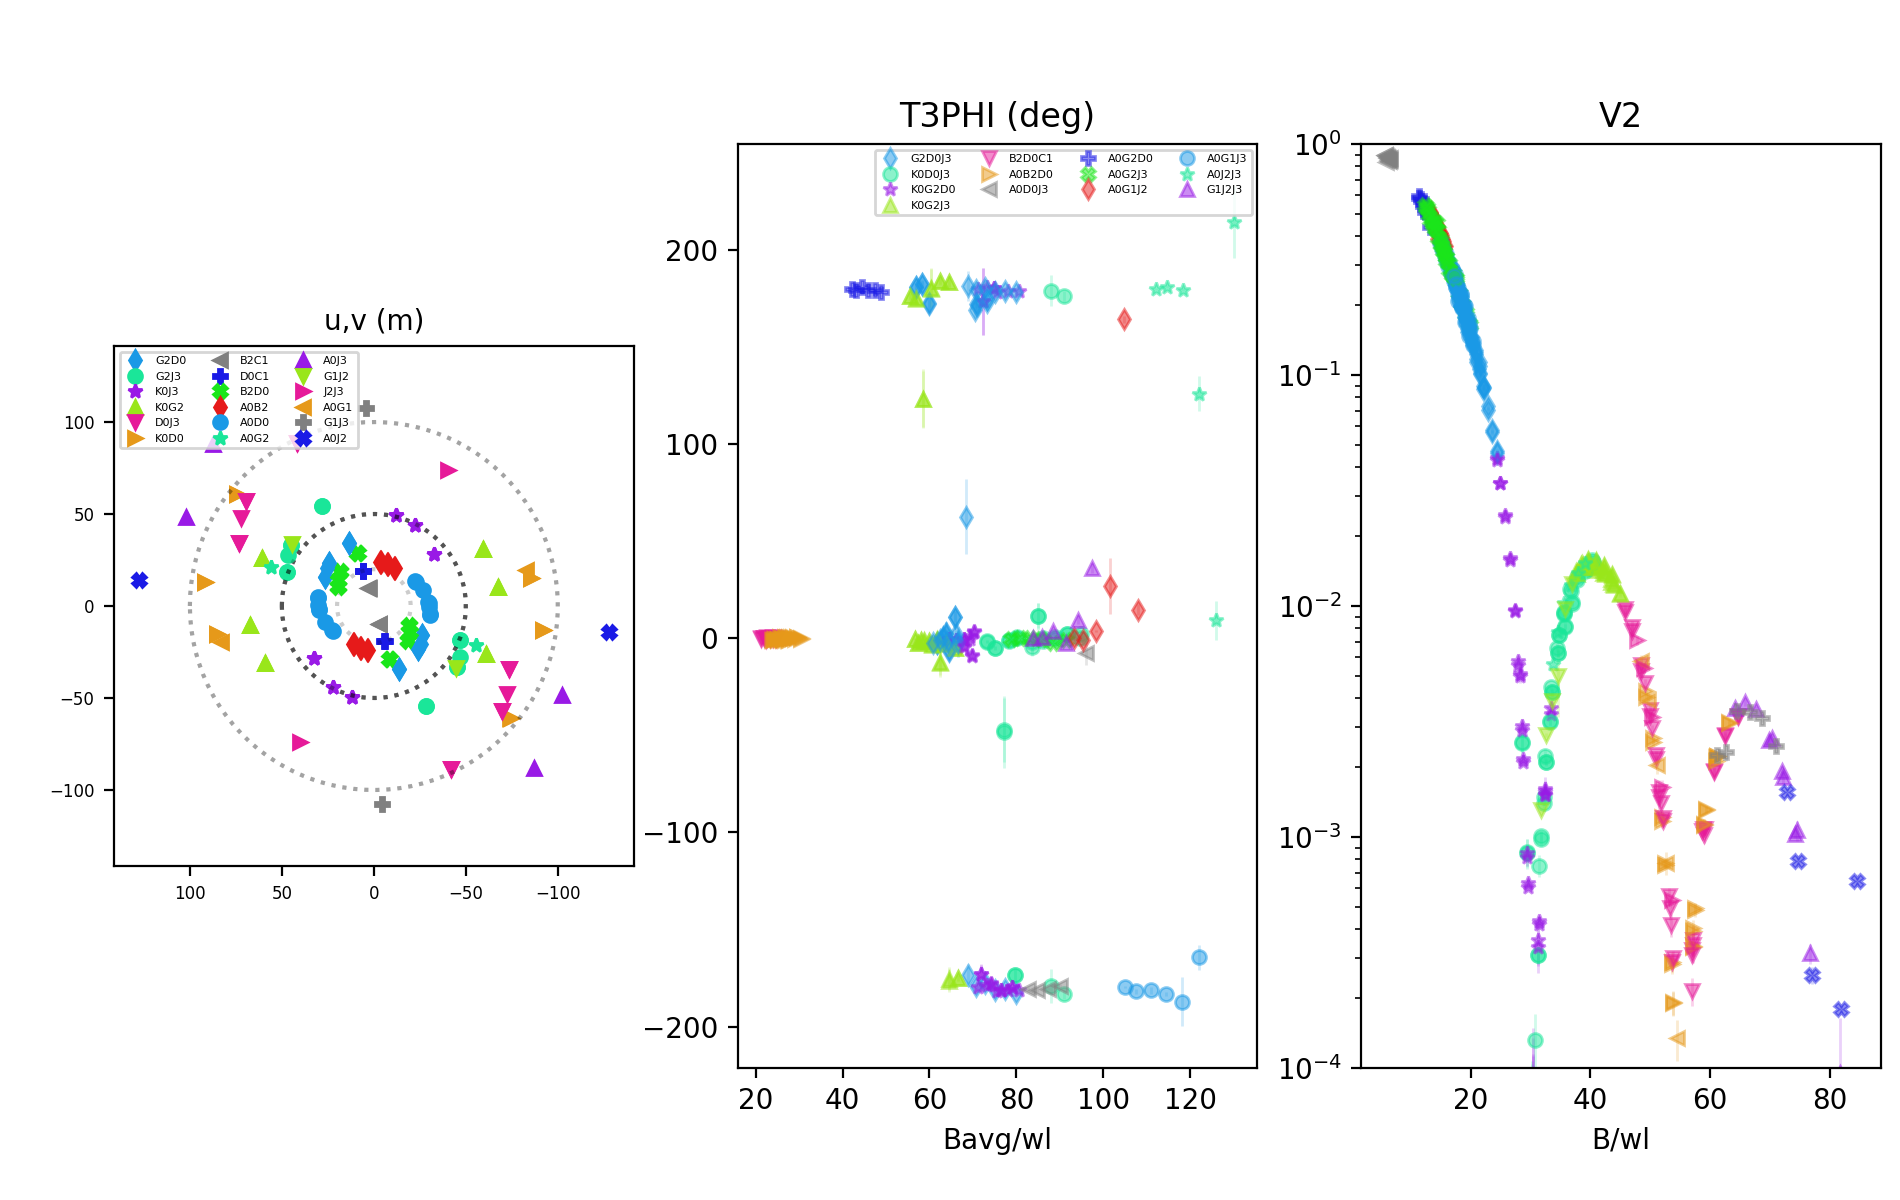

In [4]:
oi.show(allInOne=1, logV=1)

## Fit uniform disk model
In order to fit, we need to set up with method `setupFit` using a dict containing the context:
- `obs`: the list of observables to take into account, in `['V2', '|V|', 'T3PHI', 'DPHI', 'NFLUX']`. `T3PHI` stands for the closure phase. In addition, there are specific observables for spectrally dospersed data: `DPHI` differential phase and `NFLUX` the flux, normalised to the continuum.
- `min error`: a dict to set the minimum error (overrinding what's in the data file) for each observable. e.g. `d['fit']['min error'] = {'V2':0.04}`
- `min relative error`: a dict to set the minimum relative error (overrinding what's in the data file) for each observable. e.g. `d['fit']['min relative error'] = {'V2':0.04}`
- `max error`: a dict to ignore data with errors larger than a certain value. e.g. `d['fit']['max error'] = {'V2':0.1}`
- `wl ranges`: list of ranges ($\lambda_{min}[\mu m]$, $\lambda_{max}[\mu m]$) to restrict fit. e.g. `d['fit']['wl ranges'] = [(1.6, 1.9), (2.2, 2.3)]`. Especially useful for spectral data, to restric fit around a single line


The fitting method, `oi.doFit` takes the first guess as input parameter: the parameters stored in a dictionnary define the model. For example, a uniform disk of 8 milli-ardsecond in diameter is  `{'ud':8.0}`. The result is a dict (`oi.bestfit`) containing (among other things):
- `best`: the dictionnary of best fit parameters
- `uncer`: the dictionnary of uncertainties for the best fit parameters
- `chi2`: the reduced chi2
- `covd`: the covariance dictionnary

The `show` method now show the data and the best fit model.

[dpfit] 1 FITTED parameters: ['ud']
[dpfit] using scipy.optimize.leastsq
[dpfit] Both actual and predicted relative reductions in the sum of squares  are at most 0.000010
[dpfit] number of function call: 9
[dpfit] time per function call: 1.925 (ms)
# --     CHI2= 8050.591091313067
# -- red CHI2= 18.507105957041535
# --     NDOF= 435
{'ud':8.2988, # +/- 0.0038
}



<IPython.core.display.Javascript object>


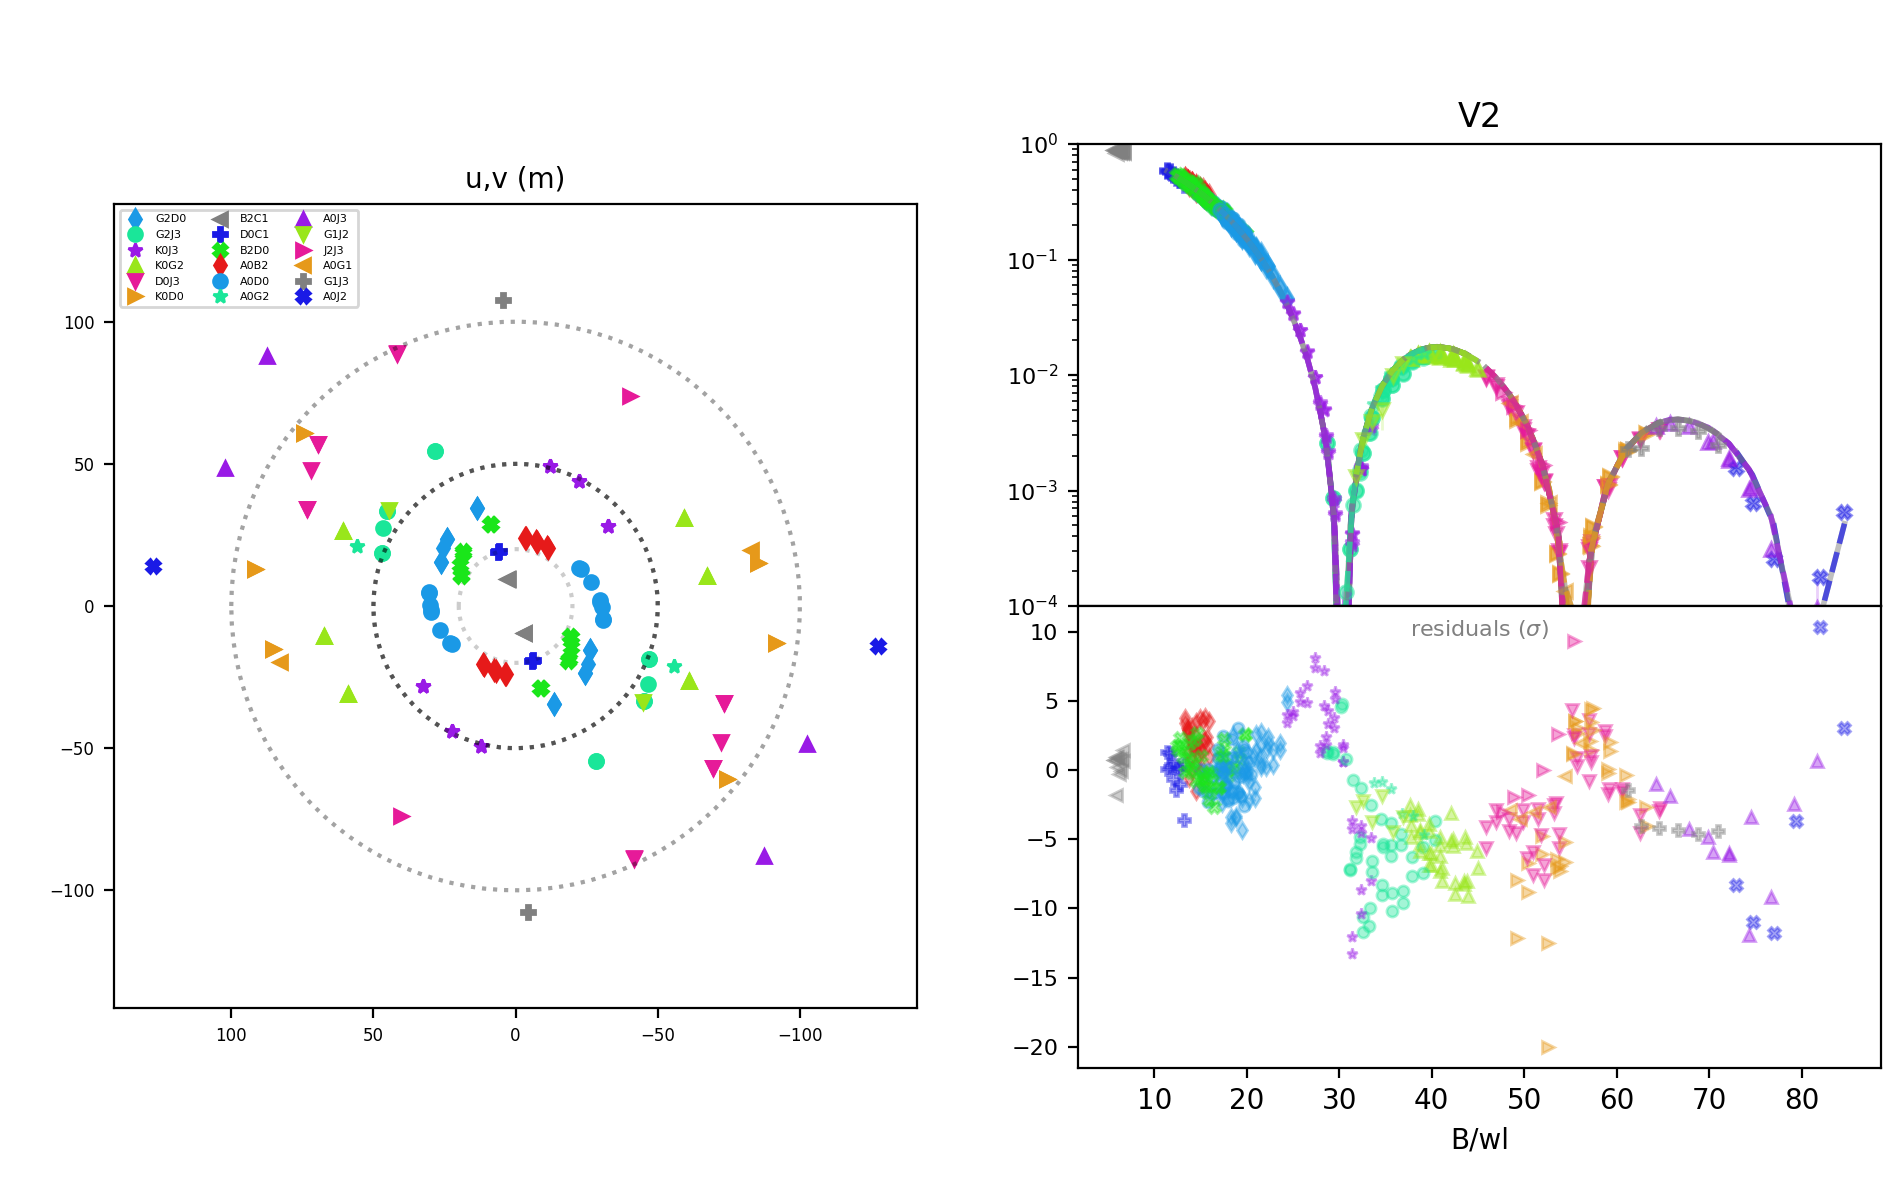

In [5]:
oi.setupFit({'obs':['V2'], 
             'min relative error':{'V2':0.01}
            })
oi.doFit({'ud':8.5})
oi.show(allInOne=1, logV=1)

## Fit a diameter with fixed Claret 4-parameters center-to-limb darkening
From Kervalla et al. A&A 597, 137 (2017), table 3:
- paper: https://ui.adsabs.harvard.edu/abs/2017A%26A...597A.137K/abstract
- table 3: https://www.aanda.org/articles/aa/full_html/2017/01/aa29505-16/T3.html

In this example, we use an arbitrary profile for the center-to-limb darkening. The `profile` for the model uses special syntax with `$R` and `$MU` for the reduced radius (0..1) and its cosine. Note that the reduced $\chi^2$ ($\sim$5.5) is much lower than for uniform disk model ($\sim$18).

We add `imFov=10` to set the field-of-view (in mas) of a synthetic image of the model. The pixel size is set to a default, but can also be adjusted using `imPix=...` with a value in mas. In this case, one can see the limb darkened compared to the center of the star. Additional parameters for image are `imX, imY`: the center of the image in mas (default 0,0); `imPow`: to show $\mathrm{image}^\mathrm{imPow}$ (default 1.0, for compressed contrast use 0<`imPow`<1); `imWl0` gives a list of wavelength to display, in microns (for chromatic models). 

Note that the model's visibility is not computed from the image, so `im...` parameters do not affect the visibility computation!

[dpfit] 1 FITTED parameters: ['diam']
[dpfit] using scipy.optimize.leastsq
[dpfit] Both actual and predicted relative reductions in the sum of squares  are at most 0.000010
[dpfit] number of function call: 13
[dpfit] time per function call: 6.406 (ms)
# --     CHI2= 2400.2505173747286
# -- red CHI2= 5.517817281321215
# --     NDOF= 435
{'diam':   8.5096, # +/- 0.0025
'profile':'1 - .7127*(1-$MU**0.5) + 0.0452*(1-$MU) + 0.2643*(1-$MU**1.5) - 0.1311*(1-$MU**2)',
}



<IPython.core.display.Javascript object>


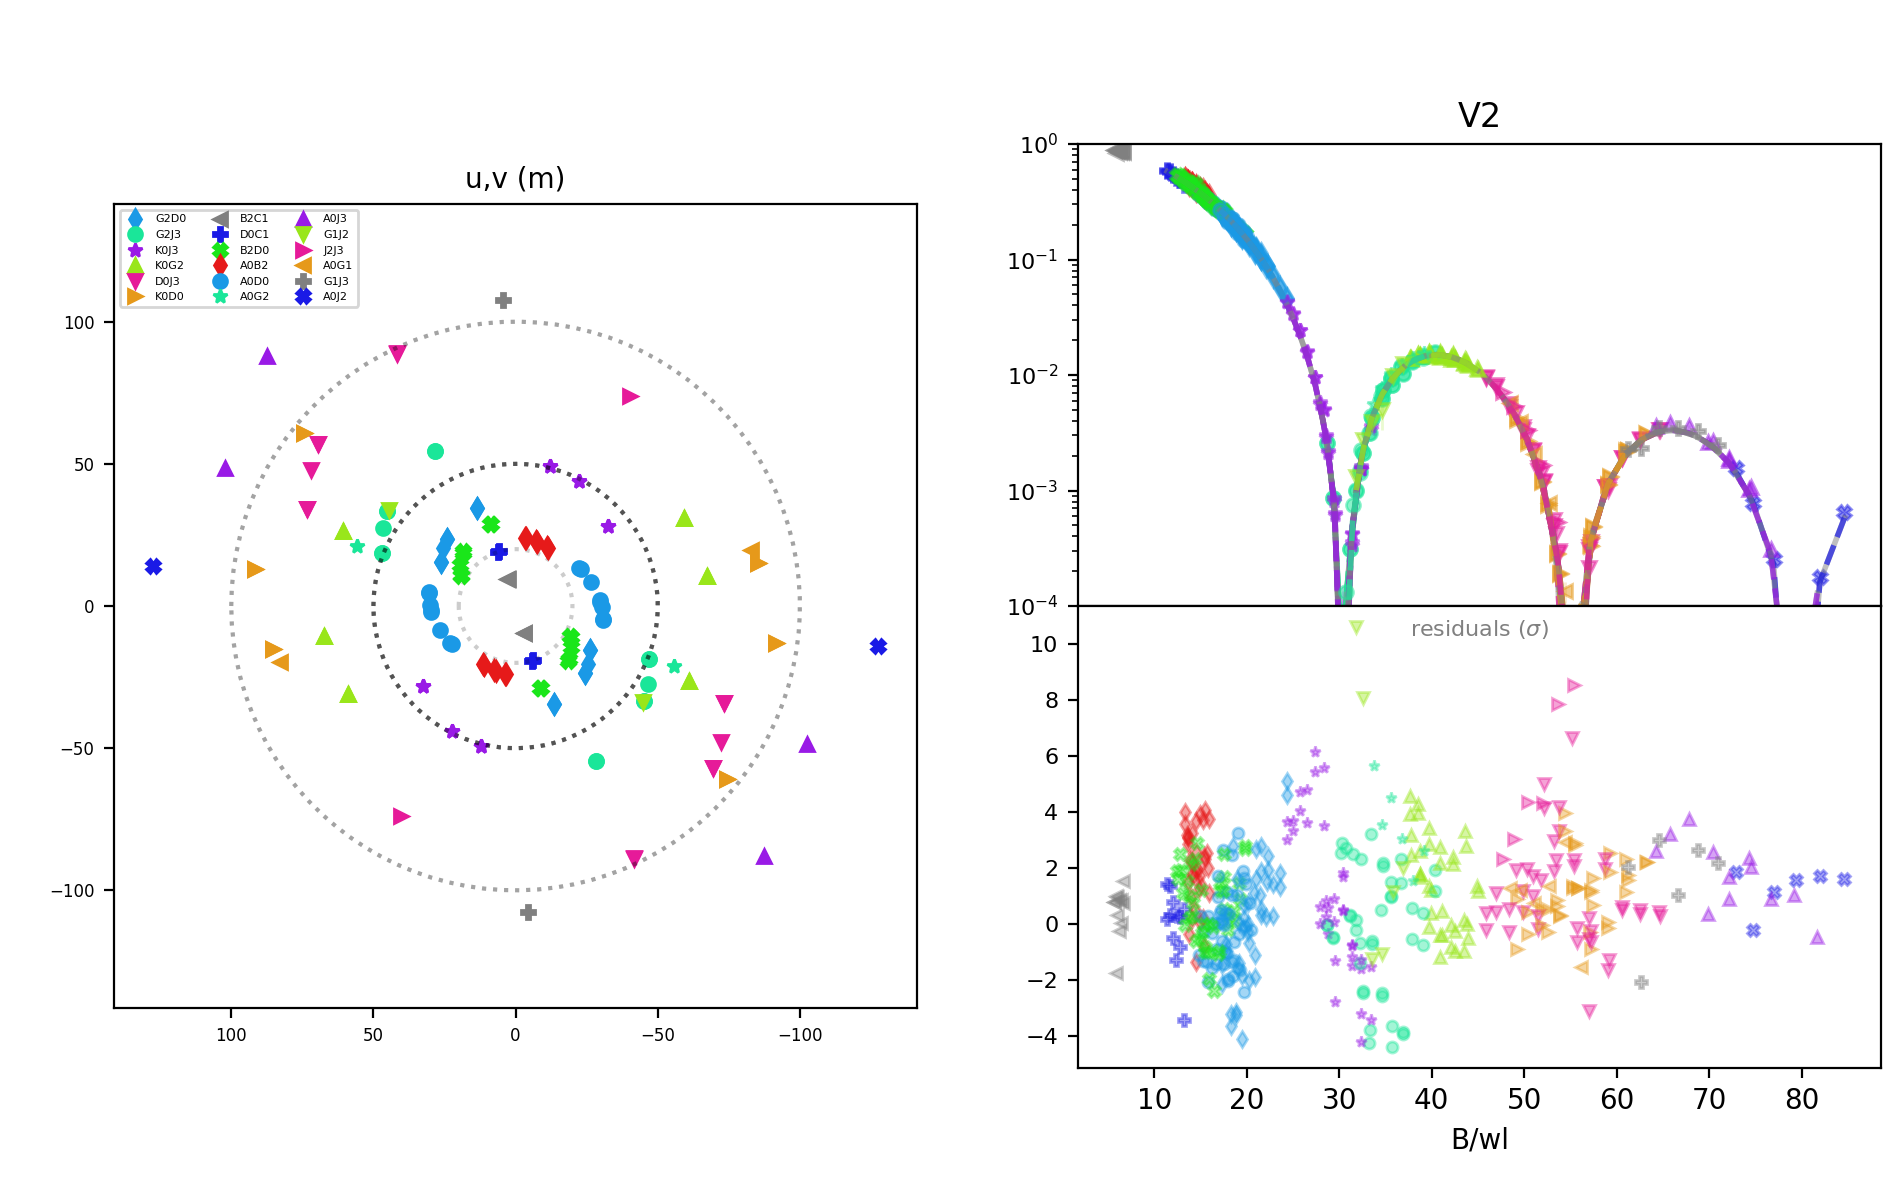

<IPython.core.display.Javascript object>


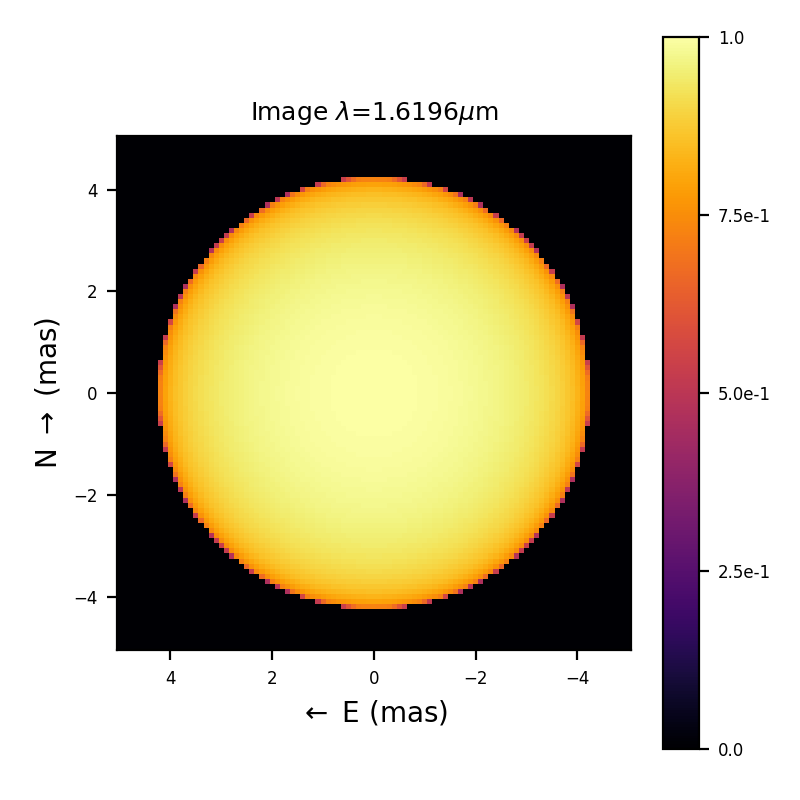

In [6]:
oi.setupFit({'obs':['V2'], 
             'min relative error':{'V2':0.01}
            })
# -- first guess with Claret 4 parameters model
oi.doFit({'diam':8., 'profile':'1 - .7127*(1-$MU**0.5) + 0.0452*(1-$MU) + 0.2643*(1-$MU**1.5) - 0.1311*(1-$MU**2)'})
oi.show(allInOne=1, logV=1, imFov=10)

## Fit a power law center-to-limb darkening
The power law center-to-limb darkening has been proposed by [Hestroffer (1997)](https://ui.adsabs.harvard.edu/abs/1997A%26A...327..199H/abstract). Here, both diameter and power law index `alpha` are fitted. When more than one parameters are fitted, correlations between parameters will be shown, whith colors to indicate the strength of the correlation. In our example below, the correlation is very high. Note that evaluation of `profile` is pretty lazy and sollely bsed on string replacement and only reckognize other parameters if they start with the special character `$`. The parameter is not to be defined with `$` in the dictionnary.

[dpfit] 2 FITTED parameters: ['alpha', 'diam']
[dpfit] using scipy.optimize.leastsq
[dpfit] Both actual and predicted relative reductions in the sum of squares  are at most 0.000010
[dpfit] number of function call: 19
[dpfit] time per function call: 6.612 (ms)
# --     CHI2= 2032.826340499648
# -- red CHI2= 4.6839316601374374
# --     NDOF= 434
{'alpha':  0.1364, # +/- 0.0045
'diam':   8.4913, # +/- 0.0054
'profile':'$MU**$alpha',
}

Correlations (%)  >=90 >=80 >=70 >=50 >=20 <20%
          0   1  
 0:alpha ###  91 
 1: diam  91 ### 


<IPython.core.display.Javascript object>


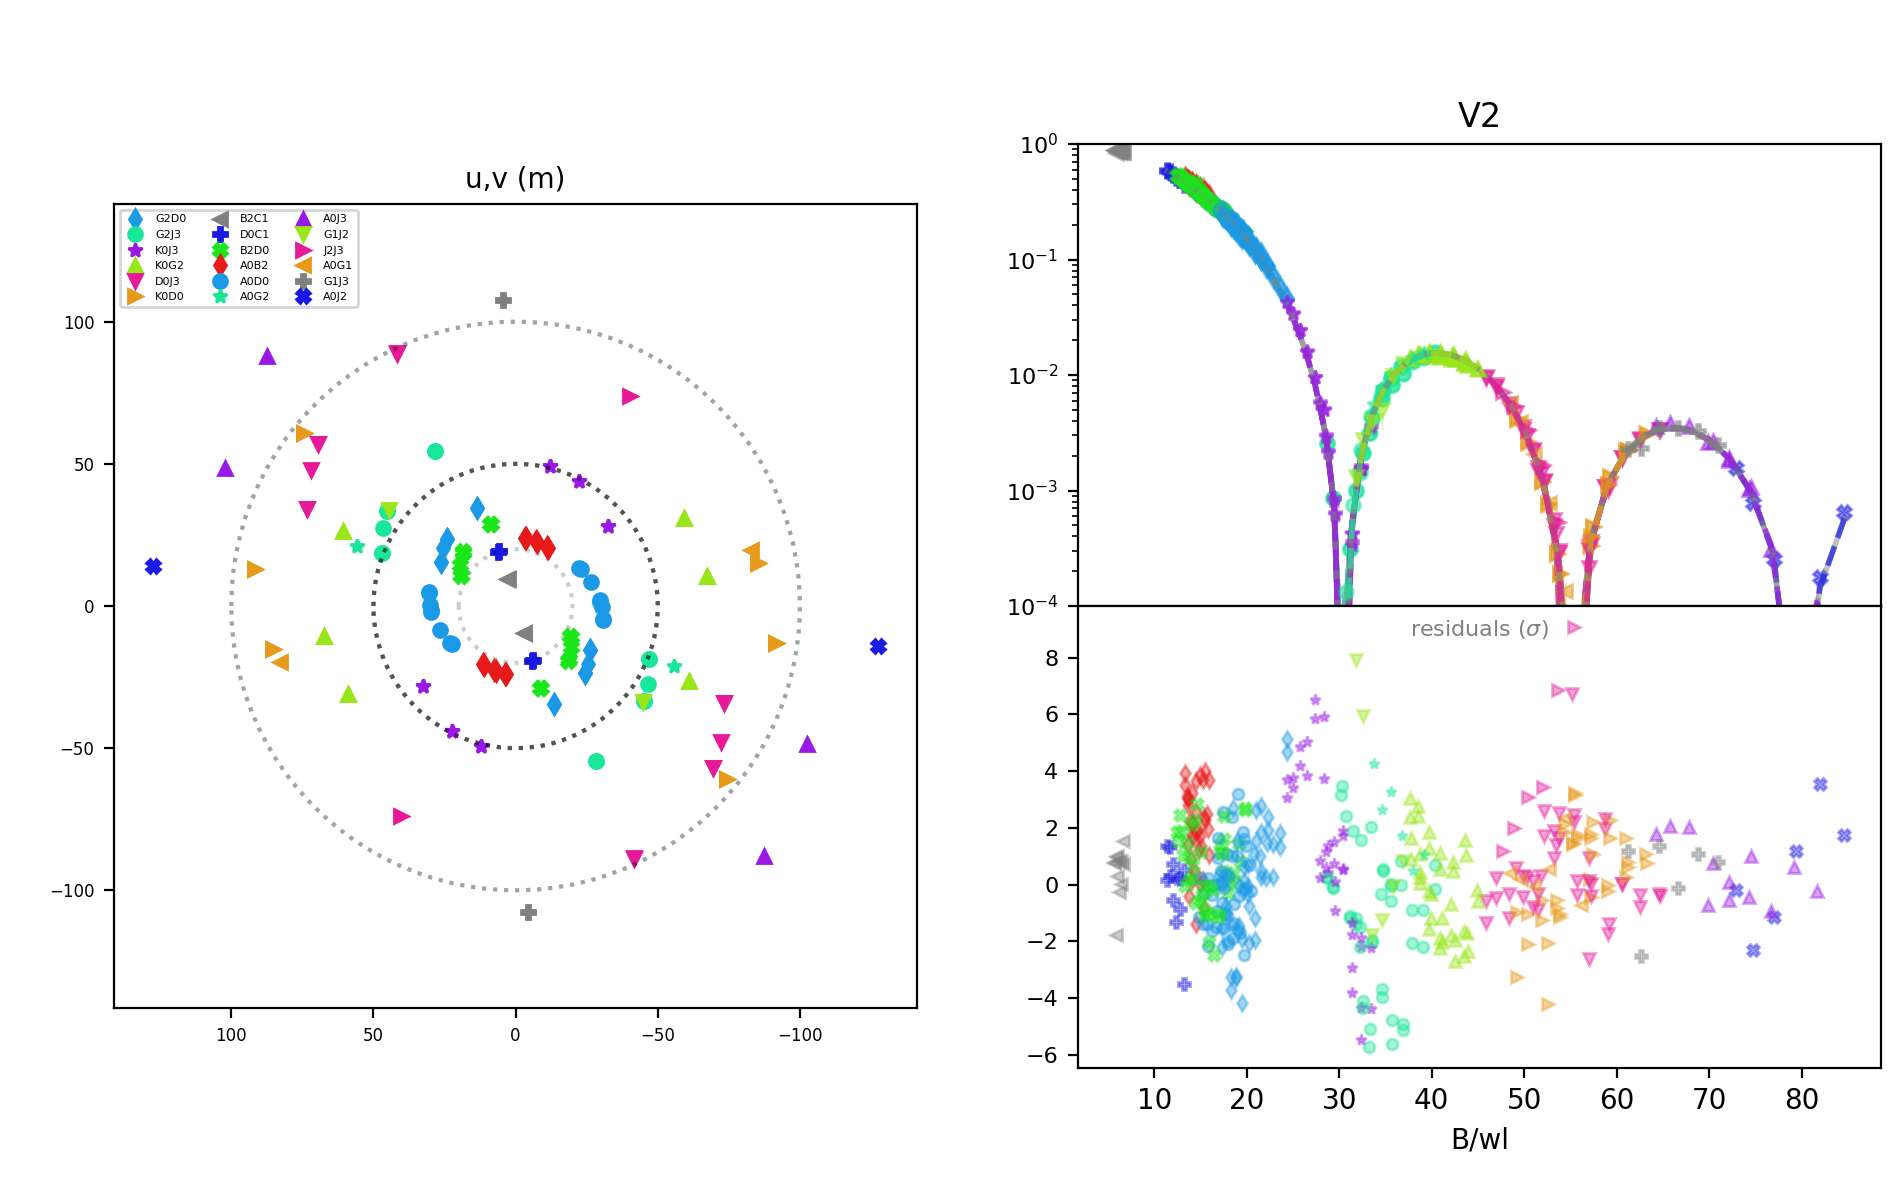

<IPython.core.display.Javascript object>


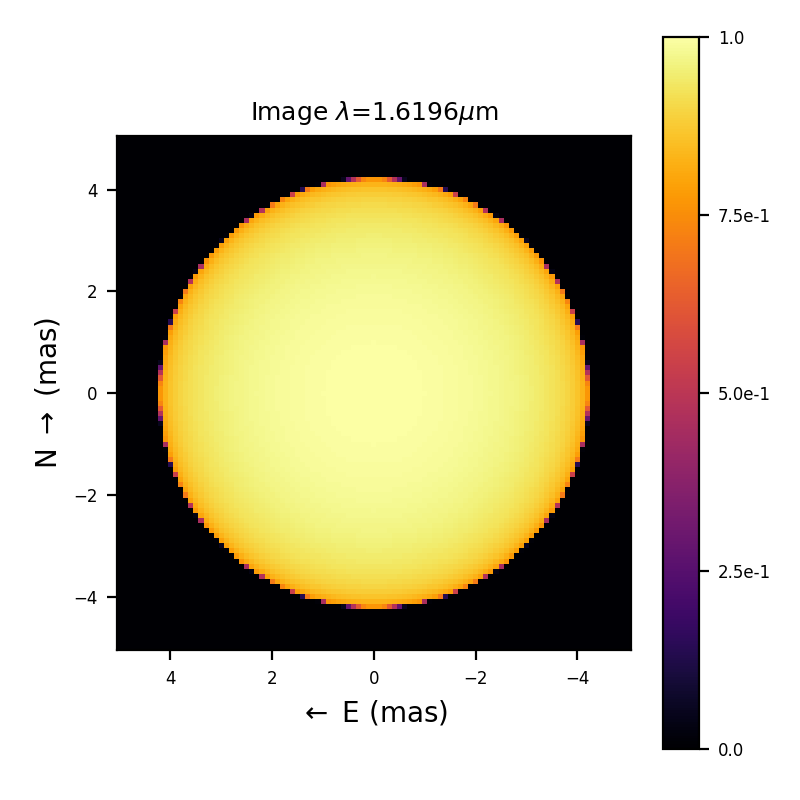

In [7]:
oi.setupFit({'obs':['V2'], 
             'min relative error':{'V2':0.01}
            })
param = {'diam':8.0, 'profile':'$MU**$alpha', 'alpha':0.5}
oi.doFit(param)
oi.show(allInOne=1, logV=True, imFov=10)

## Bootstrapping for better estimate of uncertainties
The reduced $\chi^2$ of fits are large. This seems to indicate that errors in data are understimated, or that our model is inadequate. The V2 plot seem to indicate that our model is pretty good. The absolute value of the reduced $\chi^2$ is not used in the parameters' uncertainties estimation. Rather, `PMOIRED` use the convention that uncertainties are scaled to the data scatter, to match $\chi_{red}^2=1$. 

Another way to estimate uncertainties is to bootstrap on the data and do multiple fits to estimate the scatter of the fitted parameters. It is achieved by drawing data randomly to create new data sets. The final parameters and uncertainties are estimated as the average and standard devitation of all the fits which were performed.

The default number of bootstrapped fit is 2xnumber of data, where the atomic data is a spectral vector of `V2`, `|V|`, `T3PHI` etc. You can set this by hand using `Nfits=` keyword in `bootstrapFit`. To accelerate the computation, it is parallelized. `bootstrapFit` can take an additional parameter, `multi=`, to set the number of threads in case you do not wish to swamp your computer with too much activity.

The bootstrap fits are filtered using a recursive sigma clipping algorithm. You can analyse the results by using `showBootstrap` with option `sigmaClipping` (default is 4.5). `showBootstrap` shows the scatter plots and histograms, as well as as comparison with the fit to all data and its uncertainties. When more than one parameter is explored, covariance is computed from the 2D scatter plot. `showChi2=True` also shows the scatter plot for reduced $\chi^2$.

In [8]:
oi.bootstrapFit()

Tue Jun 29 10:44:58 2021: running 144 fits on 8 processes
  one fit takes ~0.37s [~160.7 fit/minutes]
Tue Jun 29 10:45:01 2021: approx 50.8s remaining
Tue Jun 29 10:45:11 2021: it took 12.9s, 0.09s per fit on average [668.5 fit/minutes]
using 144 fits out of 144 (sigma clipping 4.50)
{'alpha'  : 0.1362, # +/- 0.0061
'diam'   : 8.4914, # +/- 0.0062
'profile':'$MU**$alpha'
}
Correlations (%)  >=90 >=80 >=70 >=50 >=20 <20%
          0   1  
 0:alpha ###  81 -44 
 1: diam  81 ### -40 


<IPython.core.display.Javascript object>


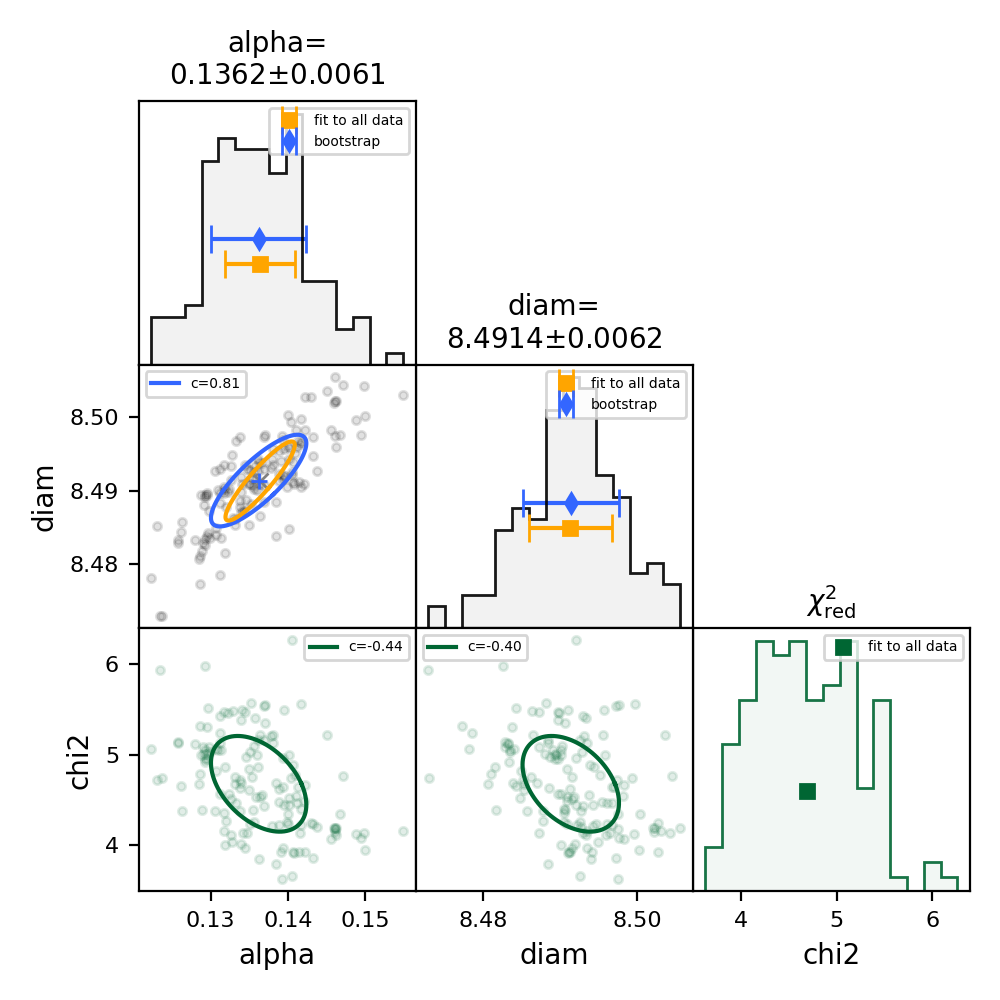

In [9]:
oi.showBootstrap(showChi2=True)

# Advanced features

## How to access the parameters of the fit, uncertainties and correlations 
The dictionnary `oi.bestfit` contains the result of the fitting process. The information there are mostly self-explantory

In [10]:
print('* best fit parameters:')
print('   fit: ', oi.bestfit['best'])
print('   boot:', oi.boot['best'])

print("* parameters' uncertainties:")
print('   fit: ', oi.bestfit['uncer'])
print('   boot:', oi.boot['uncer'])

print("* parameters' correlations (dict):")
print('   fit: ', oi.bestfit['cord'])
print('   boot:', oi.boot['cord'])

* best fit parameters:
   fit:  {'profile': '$MU**$alpha', 'alpha': 0.13641005407078177, 'diam': 8.491308384272878}
   boot: {'alpha': 0.1362177554918932, 'diam': 8.491367642612305, 'profile': '$MU**$alpha'}
* parameters' uncertainties:
   fit:  {'profile': 0, 'alpha': 0.0044812090476914574, 'diam': 0.005386545231619653}
   boot: {'alpha': 0.006145739656241245, 'diam': 0.006221598545313434, 'profile': 0.0}
* parameters' correlations (dict):
   fit:  {'alpha': {'alpha': 1.0000000000000002, 'diam': 0.9105747875921418}, 'diam': {'alpha': 0.9105747875921418, 'diam': 0.9999999999999999}}
   boot: {'alpha': {'alpha': 1.0000000000000002, 'diam': 0.8139832563384694, 'chi2': -0.4397444090296906}, 'diam': {'alpha': 0.8139832563384694, 'diam': 0.9999999999999998, 'chi2': -0.39827921160092794}, 'chi2': {'alpha': -0.4397444090296906, 'diam': -0.39827921160092794, 'chi2': 1.0000000000000002}}


## Check how the fitted parameter and $\chi^2$ evolved during the minimisation
It can be interesting to check how the parameters evolved during the fitting process. The method `showFit` displays the information contained in `bestfit`, in particular `bestfit['track']`. For each parameter, the orange line and shadded area show the best fitted value and uncertainties. Data are plotted as function of iteration number.

<IPython.core.display.Javascript object>


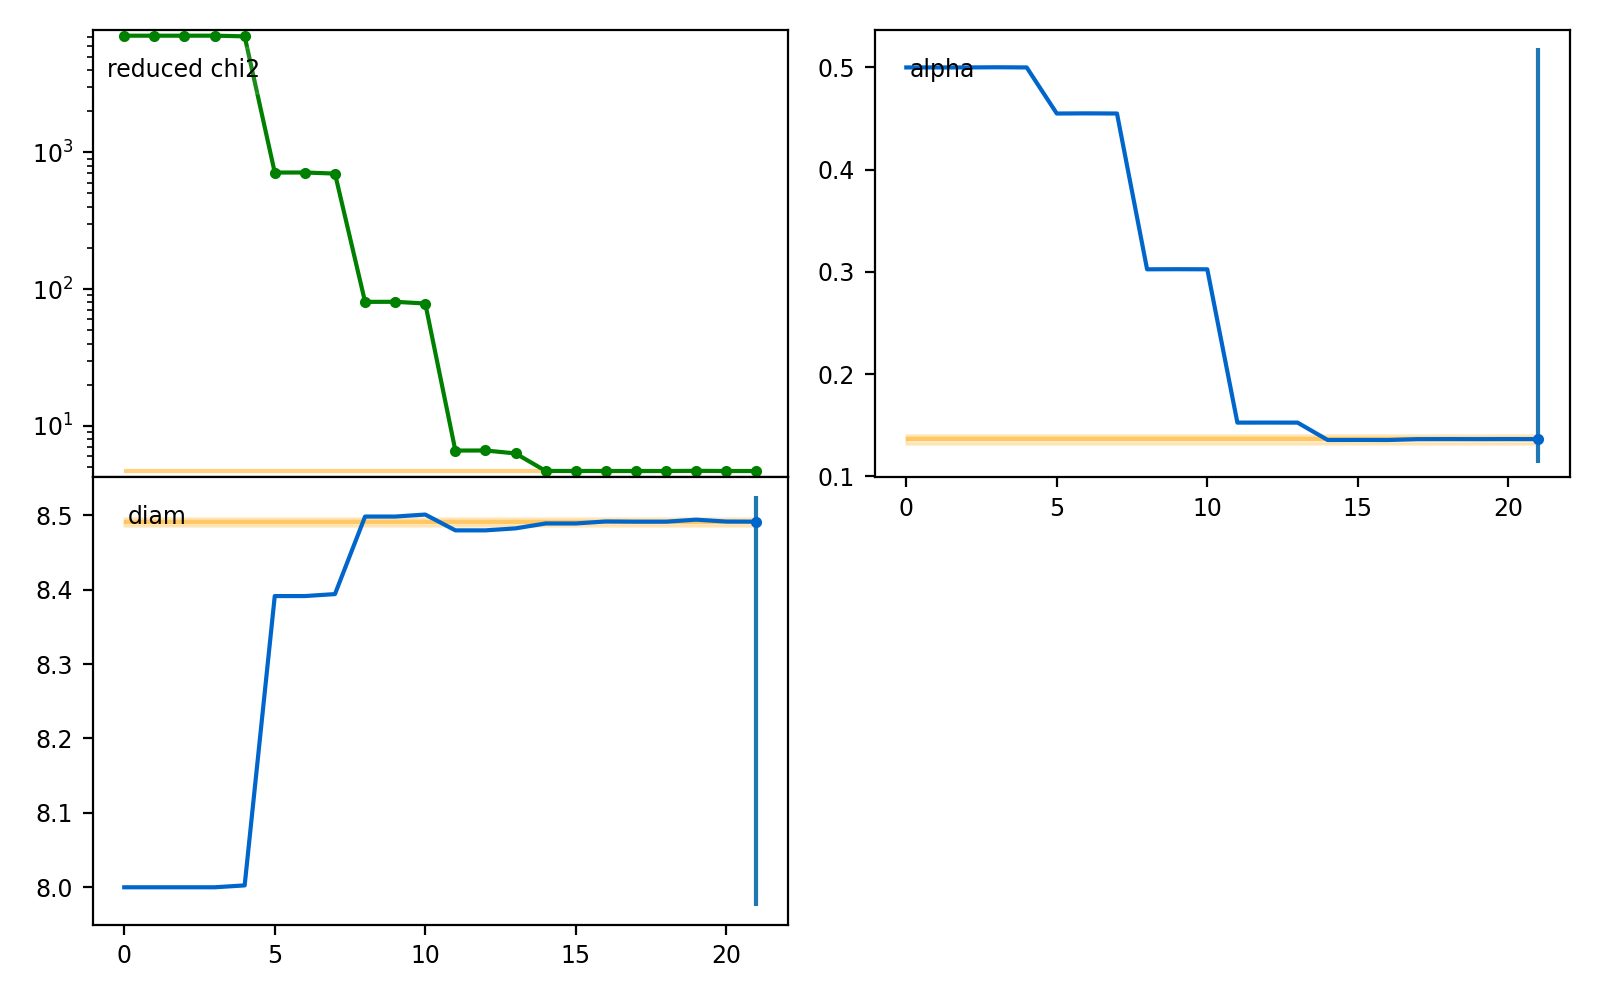

In [11]:
oi.showFit()